Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Implementação Concisa de Redes Neurais Recorrentes
:label:`sec_rnn-concise`

Embora :numref:`sec_rnn_scratch` tenha sido instrutivo para ver como RNNs são implementados,
isso não é conveniente ou rápido.
Esta seção mostrará como implementar o mesmo modelo de linguagem de forma mais eficiente
usando funções fornecidas por APIs de alto nível
de uma estrutura de aprendizado profundo.
Começamos como antes, lendo o conjunto de dados da máquina do tempo.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## Definindo o Modelo

APIs de alto nível fornecem implementações de redes neurais recorrentes.
Construímos a camada de rede neural recorrente `rnn_layer` com uma única camada oculta e 256 unidades ocultas.
Na verdade, ainda não discutimos o que significa ter várias camadas --- isso vai acontecer em :numref:`sec_deep_rnn`.
Por enquanto, basta dizer que várias camadas simplesmente equivalem à saída de uma camada de RNN sendo usada como entrada para a próxima camada de RNN.


In [2]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

Usamos um tensor para inicializar o estado oculto,
cuja forma é
(número de camadas ocultas, tamanho do lote, número de unidades ocultas).


In [3]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

Com um estado oculto e uma entrada,
podemos calcular a saída com
o estado oculto atualizado.
Deve ser enfatizado que
a "saída" (`Y`) de` rnn_layer`
*não* envolve computação de camadas de saída:
isso se refere a
o estado oculto em *cada* passo de tempo,
e eles podem ser usados como entrada
para a camada de saída subsequente.


In [4]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Semelhante a :numref:`sec_rnn_scratch`,
nós definimos uma classe `RNNModel`
para um modelo RNN completo.
Observe que `rnn_layer` contém apenas as camadas recorrentes ocultas, precisamos criar uma camada de saída separada.


In [5]:
#@save
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

## Treinamento e Previsão

Antes de treinar o modelo, façamos uma previsão com um modelo que possui pesos aleatórios.


In [6]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time traveller<unk>j<unk>j<unk>j<unk>j<unk>j'

Como é bastante óbvio, este modelo não funciona. Em seguida, chamamos `train_ch8` com os mesmos hiperparâmetros definidos em :numref:`sec_rnn_scratch` e treinamos nosso modelo com APIs de alto nível.


perplexity 1.3, 296232.7 tokens/sec on cuda:0
time travellerif f uplyond ur very ctispsoubstorne filburmy the 


travelleryou can spon whis asmered the provincill sorkent m


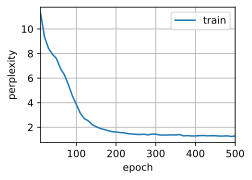

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

Comparado com a última seção, este modelo atinge perplexidade comparável,
embora dentro de um período de tempo mais curto, devido ao código ser mais otimizado por
APIs de alto nível da estrutura de aprendizado profundo.


## Resumo

* APIs de alto nível da estrutura de *deep learning* fornecem uma implementação da camada RNN.
* A camada RNN de APIs de alto nível retorna uma saída e um estado oculto atualizado, em que a saída não envolve computação da camada de saída.
* Usar APIs de alto nível leva a um treinamento RNN mais rápido do que usar sua implementação do zero.

## Exercícios

1. Você pode fazer o modelo RNN sobreajustar usando as APIs de alto nível?
1. O que acontece se você aumentar o número de camadas ocultas no modelo RNN? Você pode fazer o modelo funcionar?
1. Implemente o modelo autoregressivo de :numref:`sec_sequence` usando um RNN.


[Discussions](https://discuss.d2l.ai/t/1053)


<!--stackedit_data:
eyJoaXN0b3J5IjpbNTM4NTA4MjI0LDEyMzE3ODk1NSwtMTc5NT
g2OTU2Ml19
-->
